In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import time

# Set up variables

In [2]:
# Problem data.
m = 4
n_values = [25, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
b = np.ones(m)

In [3]:
# Number of times to solve the dual equation.
num_dual_samples = 100

# Number of times to solve the stochastic equation.
num_stoc_samples = 10**5

In [4]:
# Set random seed for reproducability.

np.random.seed(23)

# Solve for the stochastic program

In [5]:
# Solve for the stochastic program.

# This is deterministic.

# From TA office hours: We cannot use the expectations
# of A and pi instead of their samples of A and pi,
# because we cannot exchange the function and inequality.
# Therefore, we have to generate very many samples of A 
# and pi, and truly calculate the expectation.
print("Stochastic Program Results")

# Create dictionary to store stochastic program results
n_to_stochastic_p = dict()

start = time.time()

for n in n_values:
    # Solve the stochastic problem.
    d = b / n
    
    # Construct the stochastic problem.
    p = cp.Variable(m)
    
    coin_flip = np.random.choice([1, 0], p=[.5, .5])
    A = np.full((m, num_stoc_samples), coin_flip)
    pi = coin_flip
        
    objective = cp.Minimize((d @ p) + (1/num_stoc_samples)*cp.sum(cp.maximum(0,pi - (np.transpose(A) @ p))))

    constraints = [p >= 0]

    prob = cp.Problem(objective, constraints)

    # Solve the stochastic problem.
    result = prob.solve()
    now = time.time()
    print("\nWith n=%d, iteration completed in %.2f s" % (n, now - start))
    print(p.value)
    
    n_to_stochastic_p[n] = p.value
    

Stochastic Program Results

With n=25, iteration completed in 0.66 s
[-2.72307716e-15 -2.72307716e-15 -2.72307716e-15 -2.72307716e-15]

With n=50, iteration completed in 1.29 s
[4.35728746e-15 4.35728746e-15 4.35728746e-15 4.35728746e-15]

With n=100, iteration completed in 1.92 s
[-8.6333929e-16 -8.6333929e-16 -8.6333929e-16 -8.6333929e-16]

With n=200, iteration completed in 3.43 s
[0.25 0.25 0.25 0.25]

With n=300, iteration completed in 4.94 s
[0.25 0.25 0.25 0.25]

With n=400, iteration completed in 5.60 s
[-8.5380908e-16 -8.5380908e-16 -8.5380908e-16 -8.5380908e-16]

With n=500, iteration completed in 7.11 s
[0.25 0.25 0.25 0.25]

With n=600, iteration completed in 8.67 s
[0.24999999 0.25       0.25       0.25      ]

With n=700, iteration completed in 9.31 s
[-8.41393283e-16 -8.41393283e-16 -8.41393283e-16 -8.41393283e-16]

With n=800, iteration completed in 10.87 s
[0.25000001 0.25       0.25       0.25      ]

With n=900, iteration completed in 12.38 s
[0.25 0.25 0.25 0.25]

W

In [6]:
# helper method to help us confirm whether the
# matrix is positive definite

def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

coin_flip = np.random.choice([1, 0], p=[.5, .5])
A = np.full((m, num_stoc_samples), coin_flip)
is_pos_def(A@np.transpose(A))

False

# Solve for the dual problem for various values of n

In [7]:
# Create dictionaries to save results of simulations

n_to_diffs = dict()
n_to_mean_diffs = dict()
n_to_log_factors = dict()
n_to_C = dict()

##########################################################
# Solve the dual problem.
    
for n in n_values:
    d = b / n
    
    # Create an array to store all of the simulations.
    p_n_values = np.zeros((num_dual_samples, m))
    
    # Solve for one iteration of the offline dual optimal solution.
    for i in range(num_dual_samples):
        # Generate sample A_j and pi_j's (all at once in array)
        
        coin_flip = np.random.choice([1, 0], p=[.5, .5])
        A = np.full((m, n), coin_flip)
        pi = np.random.uniform(0, 10, n)

        
        # Construct the stochastic problem.
        p_n = cp.Variable(m)

        # We could do the sum of up to t terms if this was truly online;
        # however since this is offline we can use matrix operations.

        objective = cp.Minimize((d @ p_n) + (1/n)*cp.sum(cp.maximum(0,pi - (np.transpose(A) @ p_n))))

        constraints = [p_n >= 0]

        prob = cp.Problem(objective, constraints)

        # Solve the offline dual problem.
        result = prob.solve()

        p_n_values[i] = p_n.value
        
        
    
    # Compute the 2-norm difference from the stochastic solution
    diffs = [np.linalg.norm(p_n_values[i]-n_to_stochastic_p[n], ord=2)**2 for i in range(num_dual_samples)]
    
    # Compute the log difference based on m and n
    log_factor = m*np.log(m)*np.log(np.log(n))/n
    
    # Compute the coefficient C from dividing the mean of the differences by the log_factor
    C = np.mean(diffs) / log_factor
    
    # Save all results to the dictionary
    n_to_diffs[n] = diffs
    n_to_mean_diffs[n] = np.mean(diffs)
    n_to_log_factors[n] = log_factor
    n_to_C[n] = C
    
    # Print results
    print("For n = %d" % (n))
    print("Average of all dual solutions: %s" % (np.mean(p_n_values, axis=0)))
    print("Expectation of L2 norm between p*n and p* is: %.2f" % (np.mean(diffs)))
    print("m log m log log n / n for m=%d and n=%d is: %.2f" % (m, n, log_factor))
    print("Constant C is: %.3f\n" % (C))

For n = 25
Average of all dual solutions: [1.07041267 1.07041267 1.07041267 1.07041267]
Expectation of L2 norm between p*n and p* is: 9.99
m log m log log n / n for m=4 and n=25 is: 0.26
Constant C is: 38.538

For n = 50
Average of all dual solutions: [1.40802992 1.40802992 1.40802992 1.40802992]
Expectation of L2 norm between p*n and p* is: 13.68
m log m log log n / n for m=4 and n=50 is: 0.15
Constant C is: 90.428

For n = 100
Average of all dual solutions: [1.3549232 1.3549232 1.3549232 1.3549232]
Expectation of L2 norm between p*n and p* is: 13.35
m log m log log n / n for m=4 and n=100 is: 0.08
Constant C is: 157.675

For n = 200
Average of all dual solutions: [1.26536445 1.26536445 1.26536445 1.26536445]
Expectation of L2 norm between p*n and p* is: 10.28
m log m log log n / n for m=4 and n=200 is: 0.05
Constant C is: 222.315

For n = 300
Average of all dual solutions: [1.09489674 1.09489674 1.09489674 1.09489674]
Expectation of L2 norm between p*n and p* is: 8.96
m log m log log

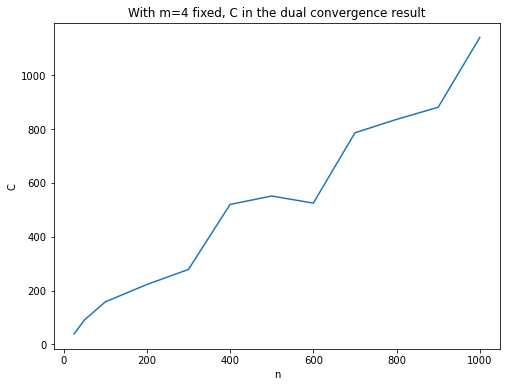

In [8]:
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(list(n_to_C.keys()), list(n_to_C.values()))
plt.xlabel("n")
plt.ylabel("C")
plt.title("With m=%d fixed, C in the dual convergence result" % (m))
plt.show()

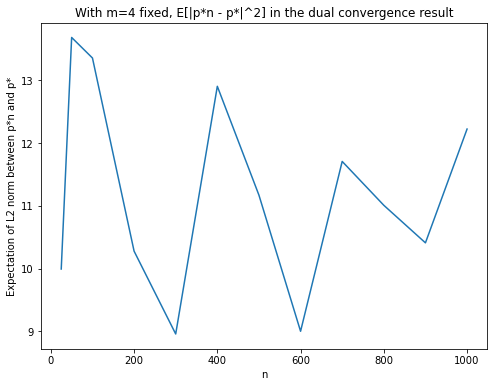

In [9]:
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(list(n_to_diffs.keys()), list(n_to_mean_diffs.values()))
plt.xlabel("n")
plt.ylabel("Expectation of L2 norm between p*n and p*")
plt.title("With m=%d fixed, E[|p*n - p*|^2] in the dual convergence result" % (m))
plt.show()

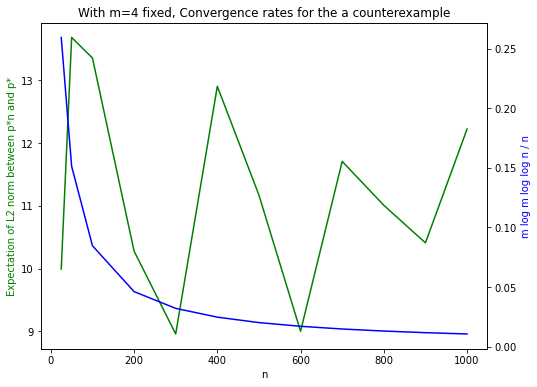

In [11]:
fig, ax1 = plt.subplots(figsize=(8,6))


ax2 = ax1.twinx()

x = list(n_to_diffs.keys())
y1 = list(n_to_mean_diffs.values())
y2 = [m*np.log(m)*np.log(np.log(n))/n for n in x]

ax1.plot(x, y1, 'g-', label="Expectation of L2 norm between p*n and p*")
ax2.plot(x, y2, 'b-', label='m log m log log n / n')
ax1.set_xlabel("n")
ax1.set_ylabel("Expectation of L2 norm between p*n and p*", color='g')
ax2.set_ylabel("m log m log log n / n", color='b')
plt.title("With m=%d fixed, Convergence rates for the a counterexample" % (m))
#plt.legend()

plt.show()